# IBM Applied Data Science Capstone Project

#### _Predict the accident severity for vehicle GPS system_
---

## 1. Introduction

Nowadays people rely more and more on vehicle GPS for navigation. Even at an unfamiliar area, people will feel much more confident at driving than ever before but neglect some safety issue sometimes. Driving at an unfamiliar street, it's not enough to know the road or traffic condition. Safety is always at priority to be considered. It's of obiligation and necessicity for GPS producer to add the feature for predicting the accident severity considerred considering all the relevant information, e.g. weather, road condition, real-time traffic, etc. Wouldn't it be great of a vehicle GPS being able to warn the driver of all the possible accidents ahead? So driver could keep careful ahead of time or even change route if being able to. Taking care of what consumers really need, even if they are not aware, is the way to succeed. 

Machine learning has been a trustworthy role in solving such problem. With abundant data, we can develop a model predicting the accident severity or even possibility for each route head and thus the GPS can help pick the safest route for the drivers and warn them to pay more attention when they drive into a risky area, like a busy and wet crossroad with no roadlight. With classification models, such as logistic regression, machine learning can easily handle such task.

This project will explore machine learning models, such as decision tree, SVM, logistic regression, random forest, ect., to provide accurate prediction of accident severity, and also the corresponding possibility with some models.

## 2. Data 

To solve the problem, we use the [shared data](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv) provided by the course. The shared data set consistes of all-year collisions provided by SPD and recorded by Traffic Records, which provides all types of collisions displayed at the intersection or mid-block of a segment from 2004 to present. Within the dataset, there're 38 columns and 194674 rows. Among the 38 columns, we have our target variable
* _SEVERITYCODE_, which corresponds to the severity of the collision: **3**-fatality, **2b**-severe injury, **2**-injury, **1**-prop damage, **0**-unkown.


For the rest 37 columns, not all columns are useful and some columns have much missing data. We have to consider what to keep and what to drop in the following sections as we perform data analysis and model evaluation. But we can start with some numerical or categorical variables that may intuitively relate to the accident severity: 
* _LOCATION_ including longitude _X_ and latitude _Y_
* _ROADCOND_, the condition of the road during the collision, like DRY or WET
* _WEATHER_, a description of the weather conditions during the time of the collision, like RAINING or CLEAR
* _JUNCTIONTYPE_, category of junction at which collision took place, like At Intersection, Mid-Block or Driveway Junction
* _SPEEDING_, whether or not speeding was a factor in the collision (Y/N)
* _PERSONCOUNT_, the total number of people involved in the collision 
* _VEHCOUNT_, the number of vehicles involved in the collision
* _LIGHTCOND_, the light conditions during the collision, like Daylight, Dark - Street Lights On or Dark - No Street Lights

We can also check more detailed [meta data](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf) here.

We will analyze the quality of each attributes listed above (whether there exist lots of missing values),preprocess the data such as encoding the categorical variables and normalization of numerical variables. Afterwards, we have to check the relation with target variable by data visualization to confirm whether we should keep or drop the attributes.

## 3. Methodology

### 3.1 Download and prepare dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_raw = pd.read_csv("https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv",low_memory=False)
print("Dataset imported!")
df_raw.head()

Dataset imported!


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [3]:
columns_num_cat = ["SEVERITYCODE","X","Y","PERSONCOUNT","VEHCOUNT","ROADCOND","WEATHER","JUNCTIONTYPE","SPEEDING","LIGHTCOND"]
df = df_raw[columns_num_cat]
df.head()

,SEVERITYCODE,X,Y,PERSONCOUNT,VEHCOUNT,ROADCOND,WEATHER,JUNCTIONTYPE,SPEEDING,LIGHTCOND
0,2,-122.323148,47.703140,2,2,Wet,Overcast,At Intersection (intersection related),NaN,Daylight
1,1,-122.347294,47.647172,2,2,Wet,Raining,Mid-Block (not related to intersection),NaN,Dark - Street Lights On
2,1,-122.334540,47.607871,4,3,Dry,Overcast,Mid-Block (not related to intersection),NaN,Daylight
3,1,-122.334803,47.604803,3,3,Dry,Clear,Mid-Block (not related to intersection),NaN,Daylight
4,2,-122.306426,47.545739,2,2,Wet,Raining,At Intersection (intersection related),NaN,Daylight


#### Now let's plot a small subset of dataframe on the Seattle map to check where most accidents happen.

In [4]:
import json
import folium
from folium import plugins
from folium import Marker
from folium.plugins import MarkerCluster
from jinja2 import Template


In [5]:
seattle_lat,seattle_long = 47.6062,-122.3321
df_incidents = df.loc[:1000,["X","Y","SEVERITYCODE"]]
df_incidents["SEVERITYCODE"] = df_incidents["SEVERITYCODE"].astype("str")
df_incidents = df_incidents.dropna()

# let's start again with a clean copy of the map of Seattle
seattle_map = folium.Map(location = [seattle_lat, seattle_long], zoom_start = 11)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(seattle_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_incidents.Y, df_incidents.X, df_incidents.SEVERITYCODE):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# display map
seattle_map

As we can see on the map, most of accidents happen along the highway from south to north, especially around the downtown of Seattle.

But in this project, we do not study the location effect in detail because it becomes much more complicated. But as we can see from the map, with clustering method, we can figure out some areas of higher accident risk, thus GPS should warn the drivers of these risky areas.

#### Now let's drop location from attributes for now and study the rest of attributes

In [6]:
columns_num_cat = ["SEVERITYCODE","PERSONCOUNT","VEHCOUNT","ROADCOND","WEATHER","JUNCTIONTYPE","SPEEDING","LIGHTCOND"]
df = df_raw[columns_num_cat]
df.head()

,SEVERITYCODE,PERSONCOUNT,VEHCOUNT,ROADCOND,WEATHER,JUNCTIONTYPE,SPEEDING,LIGHTCOND
0,2,2,2,Wet,Overcast,At Intersection (intersection related),NaN,Daylight
1,1,2,2,Wet,Raining,Mid-Block (not related to intersection),NaN,Dark - Street Lights On
2,1,4,3,Dry,Overcast,Mid-Block (not related to intersection),NaN,Daylight
3,1,3,3,Dry,Clear,Mid-Block (not related to intersection),NaN,Daylight
4,2,2,2,Wet,Raining,At Intersection (intersection related),NaN,Daylight


In [7]:
df.describe(include="all")

,SEVERITYCODE,PERSONCOUNT,VEHCOUNT,ROADCOND,WEATHER,JUNCTIONTYPE,SPEEDING,LIGHTCOND
count,194673.000000,194673.000000,194673.000000,189661,189592,188344,9333,189503
unique,NaN,NaN,NaN,9,11,7,1,9
top,NaN,NaN,NaN,Dry,Clear,Mid-Block (not related to intersection),Y,Daylight
freq,NaN,NaN,NaN,124510,111135,89800,9333,116137
mean,1.298901,2.444427,1.920780,NaN,NaN,NaN,NaN,NaN
std,0.457778,1.345929,0.631047,NaN,NaN,NaN,NaN,NaN
min,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,1.000000,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN
50%,1.000000,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN
75%,2.000000,3.000000,2.000000,NaN,NaN,NaN,NaN,NaN


#### Let's look at each column more closely along with some visualization analysis

Check the target variable _SEVERITYCODE_ first, we can see this dataset has already been processes so that it consists of only 1 and 2. Also note that it's unbalanced between 1 and 2, thus we have to adjust this afterward when building models.

In [8]:
y = df["SEVERITYCODE"]
y.value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

##### Next, check numerical variables _PERSONCOUNT_ and _VEHCOUNT_ and check the correlation with target variable.

In [9]:
%matplotlib inline
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.3.0


In [10]:
df[["SEVERITYCODE","PERSONCOUNT","VEHCOUNT"]].corr()

,SEVERITYCODE,PERSONCOUNT,VEHCOUNT
SEVERITYCODE,1.000000,0.130949,-0.054686
PERSONCOUNT,0.130949,1.000000,0.380523
VEHCOUNT,-0.054686,0.380523,1.000000


Text(0.5, 1.0, 'Box plot between SEVERITYCODE and PERSONCOUNT')

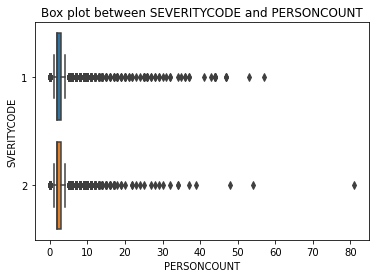

In [11]:
sns.boxplot(x="PERSONCOUNT",y="SEVERITYCODE",data = df,orient="h")
plt.xlabel("PERSONCOUNT")
plt.ylabel("SVERITYCODE")
plt.title("Box plot between SEVERITYCODE and PERSONCOUNT")

Text(0.5, 1.0, 'Box plot between SEVERITYCODE and PERSONCOUNT(exclude outliers)')

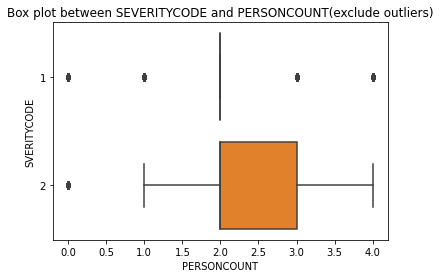

In [12]:
sns.boxplot(x="PERSONCOUNT",y="SEVERITYCODE",data = df[df["PERSONCOUNT"]<5],orient="h")
plt.xlabel("PERSONCOUNT")
plt.ylabel("SVERITYCODE")
plt.title("Box plot between SEVERITYCODE and PERSONCOUNT(exclude outliers)")

Text(0.5, 1.0, 'Box plot between SEVERITYCODE and VEHCOUNT')

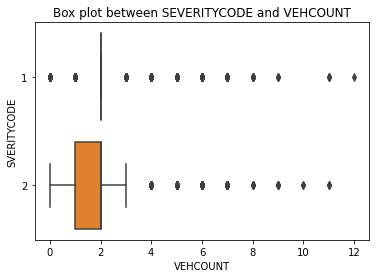

In [13]:
sns.boxplot(x="VEHCOUNT",y="SEVERITYCODE",data = df,orient="h")
plt.xlabel("VEHCOUNT")
plt.ylabel("SVERITYCODE")
plt.title("Box plot between SEVERITYCODE and VEHCOUNT")

Text(0.5, 1.0, 'Box plot between SEVERITYCODE and VEHCOUNT(exclude outliers)')

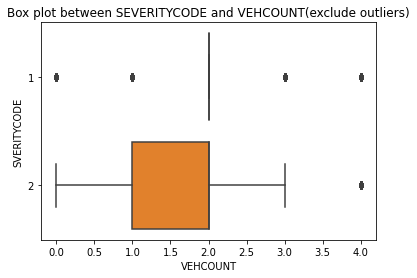

In [14]:
sns.boxplot(x="VEHCOUNT",y="SEVERITYCODE",data = df[df["VEHCOUNT"]<5],orient="h")
plt.xlabel("VEHCOUNT")
plt.ylabel("SVERITYCODE")
plt.title("Box plot between SEVERITYCODE and VEHCOUNT(exclude outliers)")

Though the correlation between _SEVERITYCODE_ and _PERSONCOUNT_, _VEHCOUNT_ is low, we can observe that the box plot after excluding outliers are different between _CODE_ 1 and 2. So we will keep these two numerical variables but truncate the value below 5.

In [25]:
df["PERSONCOUNT"].values[df["PERSONCOUNT"]>5] = 5
df["VEHCOUNT"].values[df["VEHCOUNT"]>5] = 5

##### Now, let's check the categorical variables _ROADCOND_, _WEATHER_, _JUNCTIONTYPE_, _SPEEDING_, _LIGHTCOND_.

In [16]:
df.columns

Index(['SEVERITYCODE', 'PERSONCOUNT', 'VEHCOUNT', 'ROADCOND', 'WEATHER',
       'JUNCTIONTYPE', 'SPEEDING', 'LIGHTCOND'],
      dtype='object')

##### ROADCOND

In [17]:
df["ROADCOND"].value_counts()

Dry               124510
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64

In [18]:
df[["SEVERITYCODE","ROADCOND"]].groupby(["SEVERITYCODE","ROADCOND"]).size().to_frame().squeeze()

SEVERITYCODE  ROADCOND      
1             Dry               84446
              Ice                 936
              Oil                  40
              Other                89
              Sand/Mud/Dirt        52
              Snow/Slush          837
              Standing Water       85
              Unknown           14329
              Wet               31719
2             Dry               40064
              Ice                 273
              Oil                  24
              Other                43
              Sand/Mud/Dirt        23
              Snow/Slush          167
              Standing Water       30
              Unknown             749
              Wet               15755
Name: 0, dtype: int64

In [77]:
df_roadcond = df[["SEVERITYCODE","ROADCOND"]].groupby(["SEVERITYCODE","ROADCOND"]).size().to_frame().reset_index().pivot("ROADCOND","SEVERITYCODE")[0]
df_roadcond

SEVERITYCODE,1,2
ROADCOND,,
Dry,84446,40064
Ice,936,273
Oil,40,24
Other,89,43
Sand/Mud/Dirt,52,23
Snow/Slush,837,167
Standing Water,85,30
Unknown,14329,749
Wet,31719,15755


In [78]:
df_roadcond[1],df_roadcond[2] = df_roadcond[1]/(df_roadcond[1]+df_roadcond[2]),df_roadcond[2]/(df_roadcond[1]+df_roadcond[2])
df_roadcond

SEVERITYCODE,1,2
ROADCOND,,
Dry,0.678227,0.321773
Ice,0.774194,0.225806
Oil,0.625000,0.375000
Other,0.674242,0.325758
Sand/Mud/Dirt,0.693333,0.306667
Snow/Slush,0.833665,0.166335
Standing Water,0.739130,0.260870
Unknown,0.950325,0.049675
Wet,0.668134,0.331866


Text(0.5, 1.0, 'Bar plot of severity component for different road conditions')

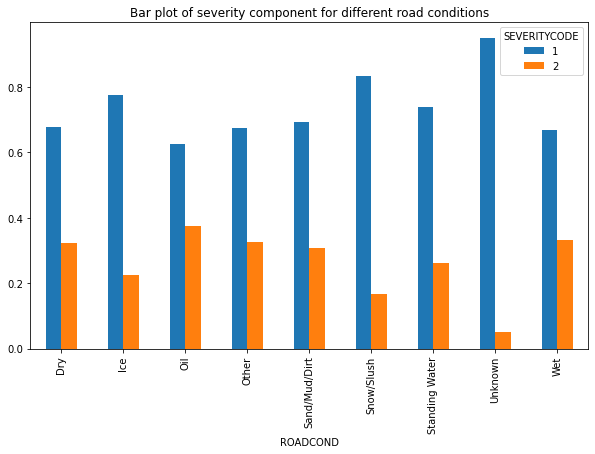

In [81]:
df_roadcond.plot(kind="bar",figsize=(10,6))
plt.title("Bar plot of severity component for different road conditions")

As we can observe from the graph above, "Oil", "Other", "Sand/Mud/Dirt" "Standing Water" look quite similar to "Wet" and "Snow/Slush" looks similar to "Ice", so that we can merge these small categories into the larger similar ones. 

In [87]:
df["ROADCOND"].values[df["ROADCOND"] == "Oil"] = "Wet"
df["ROADCOND"].values[df["ROADCOND"] == "Other"] = "Wet"
df["ROADCOND"].values[df["ROADCOND"] == "Sand/Mud/Dirt"] = "Wet"
df["ROADCOND"].values[df["ROADCOND"] == "Standing Water"] = "Wet"

df["ROADCOND"].values[df["ROADCOND"] == "Snow/Slush"] = "Ice"

df["ROADCOND"].value_counts()

Dry        124510
Wet         47860
Unknown     15078
Ice          2213
Name: ROADCOND, dtype: int64

##### WEATHER

In [90]:
df["WEATHER"].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [92]:
df_weather = df[["SEVERITYCODE","WEATHER"]].groupby(["SEVERITYCODE","WEATHER"]).size().to_frame().reset_index().pivot("WEATHER","SEVERITYCODE")[0]
df_weather[1],df_weather[2] = df_weather[1]/(df_weather[1]+df_weather[2]),df_weather[2]/(df_weather[1]+df_weather[2])
df_weather

SEVERITYCODE,1,2
WEATHER,,
Blowing Sand/Dirt,0.732143,0.267857
Clear,0.677509,0.322491
Fog/Smog/Smoke,0.671353,0.328647
Other,0.860577,0.139423
Overcast,0.684456,0.315544
Partly Cloudy,0.400000,0.600000
Raining,0.662815,0.337185
Severe Crosswind,0.720000,0.280000
Sleet/Hail/Freezing Rain,0.752212,0.247788


Text(0.5, 1.0, 'Bar plot of severity component for different weather')

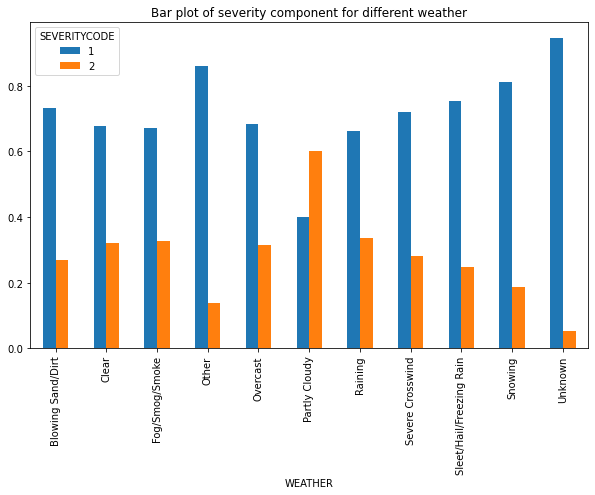

In [93]:
df_weather.plot(kind="bar",figsize=(10,6))
plt.title("Bar plot of severity component for different weather")

We did the similar work and merge some small categories into larger ones

In [94]:
df["WEATHER"].values[df["WEATHER"] == "Blowing Sand/Dirt"] = "Unknown"
df["WEATHER"].values[df["WEATHER"] == "Snowing"] = "Unknown"
df["WEATHER"].values[df["WEATHER"] == "Partly Cloudy"] = "Unknown"
df["WEATHER"].values[df["WEATHER"] == "Severe Crosswind"] = "Unknown"
df["WEATHER"].values[df["WEATHER"] == "Sleet/Hail/Freezing Rain"] = "Unknown"
df["WEATHER"].values[df["WEATHER"] == "Fog/Smog/Smoke"] = "Unknown"
df["WEATHER"].values[df["WEATHER"] == "Other"] = "Unknown"

df["WEATHER"].value_counts()

Clear       111135
Raining      33145
Overcast     27714
Unknown      17598
Name: WEATHER, dtype: int64

##### JUNCTIONTYPE

In [95]:
df["JUNCTIONTYPE"].value_counts()

Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64

In [96]:
df_junc = df[["SEVERITYCODE","JUNCTIONTYPE"]].groupby(["SEVERITYCODE","JUNCTIONTYPE"]).size().to_frame().reset_index().pivot("JUNCTIONTYPE","SEVERITYCODE")[0]
df_junc[1],df_junc[2] = df_junc[1]/(df_junc[1]+df_junc[2]),df_junc[2]/(df_junc[1]+df_junc[2])
df_junc

SEVERITYCODE,1,2
JUNCTIONTYPE,,
At Intersection (but not related to intersection),0.703051,0.296949
At Intersection (intersection related),0.567362,0.432638
Driveway Junction,0.696936,0.303064
Mid-Block (but intersection related),0.679816,0.320184
Mid-Block (not related to intersection),0.783920,0.216080
Ramp Junction,0.674699,0.325301
Unknown,0.777778,0.222222


Text(0.5, 1.0, 'Bar plot of severity component for different junction type')

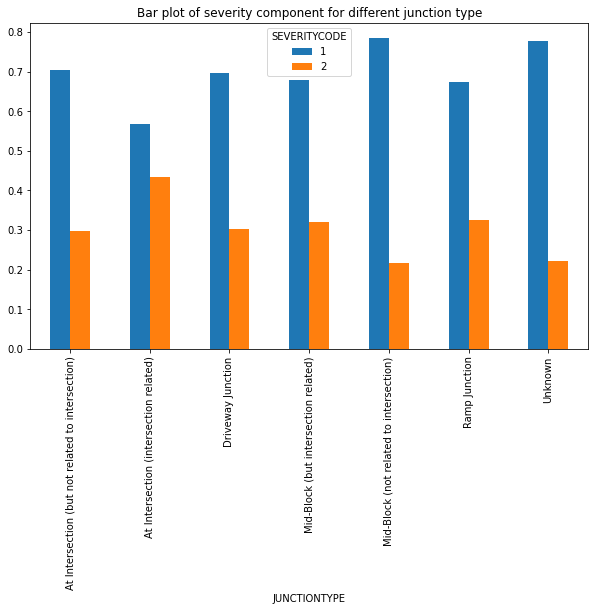

In [97]:
df_junc.plot(kind="bar",figsize=(10,6))
plt.title("Bar plot of severity component for different junction type")

So we merge the small categories into large categories according to the similarity. 

In [99]:
df["JUNCTIONTYPE"].values[df["JUNCTIONTYPE"] == "At Intersection (but not related to intersection)"] = "Driveway Junction"
df["JUNCTIONTYPE"].values[df["JUNCTIONTYPE"] == "Ramp Junction"] = "Driveway Junction"
df["JUNCTIONTYPE"].values[df["JUNCTIONTYPE"] == "Unknown"] = "Driveway Junction"

df["JUNCTIONTYPE"].value_counts()

Mid-Block (not related to intersection)    89800
At Intersection (intersection related)     62810
Mid-Block (but intersection related)       22790
Driveway Junction                          12944
Name: JUNCTIONTYPE, dtype: int64

##### SPEEDING

In [100]:
df["SPEEDING"].value_counts()

Y    9333
Name: SPEEDING, dtype: int64

From the dataset, we observe that it only contains value Y and NaN. So we replace NaN with N.

In [104]:
df["SPEEDING"].replace(np.nan,"N")
df["SPEEDING"].value_counts()

N    185340
Y      9333
Name: SPEEDING, dtype: int64

##### LIGHTCOND

In [105]:
df["LIGHTCOND"].value_counts()

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

Then we decie how to merge the categories by common sense as

In [107]:
df["LIGHTCOND"].values[df["LIGHTCOND"] == "Dusk"] = "Dark - Street Lights Off"
df["LIGHTCOND"].values[df["LIGHTCOND"] == "Dawn"] = "Dark - Street Lights Off"
df["LIGHTCOND"].values[df["LIGHTCOND"] == "Dark - No Street Lights"] = "Dark - Street Lights Off"
df["LIGHTCOND"].values[df["LIGHTCOND"] == "Other"] = "Dark - Street Lights Off"
df["LIGHTCOND"].values[df["LIGHTCOND"] == "Dark - Unknown Lighting"] = "Dark - Street Lights Off"

df["LIGHTCOND"].value_counts()

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dark - Street Lights Off     11386
Name: LIGHTCOND, dtype: int64

Eventually, we drop the rows with NaN:

In [191]:
df = df.dropna().reindex()

In [192]:
df.shape

(183196, 8)

### 3.2 DATA NORMALIZATION and ENCODING

In [193]:
from sklearn.preprocessing import StandardScaler

In [194]:
y = df["SEVERITYCODE"]
X_num = df[["PERSONCOUNT","VEHCOUNT"]]
X_cat = df[["ROADCOND","WEATHER","JUNCTIONTYPE","SPEEDING","LIGHTCOND"]]

We have to one hot encode the categorical variables with pd.get_dummies()

In [195]:
df_cat= pd.get_dummies(X_cat,drop_first=True)

In [196]:
df_cat.head()

,ROADCOND_Ice,ROADCOND_Unknown,ROADCOND_Wet,WEATHER_Overcast,WEATHER_Raining,WEATHER_Unknown,JUNCTIONTYPE_Driveway Junction,JUNCTIONTYPE_Mid-Block (but intersection related),JUNCTIONTYPE_Mid-Block (not related to intersection),SPEEDING_Y,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Daylight,LIGHTCOND_Unknown
0,0,0,1,1,0,0,0,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,1,0,1,0,0
2,0,0,0,1,0,0,0,0,1,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0,0,1,0,1,0,0,0,0,0,0,1,0


Also we have to normalize the numerical variables with StandardScaler()

In [197]:
df_num = pd.DataFrame(StandardScaler().fit_transform(X_num.astype("float")))
df_num[:5]

,0,1
0,-0.399869,0.055115
1,-0.399869,0.055115
2,1.530445,1.881266
3,0.565288,1.881266
4,-0.399869,0.055115


At last we concatenate both numerical variables and encoded categorical variables to form the feature matrix X

In [204]:
X = np.concatenate([df_num.values,df_cat.values],axis=1)
print(df_num.shape)
print(df_cat.shape)
X[:5]

(183196, 2)
(183196, 13)


array([[-0.39986942,  0.0551147 ,  0.        ,  0.        ,  1.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [-0.39986942,  0.0551147 ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 1.53044531,  1.88126646,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.56528794,  1.88126646,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [-0.39986942,  0.0551147 ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        , 

In [205]:
X.shape

(183196, 15)

### 3.3 TRAIN/TEST DATA SPLIT

In [206]:
from sklearn.model_selection import train_test_split

We have to split the dataset to train data and test data at ratio of 0.2 for further evaluation purpose.

In [208]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (146556, 15) (146556,)
Test set: (36640, 15) (36640,)


### 3.4 Model and Evaluation

In this section, we will use two kinds of models for prediction: Logistic Regression and Random Forest. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes or mean prediction of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set. Both models can do very well in classification. 

#### Logistic Regression

For Logistic Regression, there's one important hyper-parameter that we have to tune, which is C, the inverse of regularization parameter. So we have to try different C in order to find the optimal one so that the model is neither underfitted nor overfitted. And of course, we have to consider the unbalanced dataset. Conveniently, sklearn package can pass the "balanced" parameter to class_weight and thus deal with it automatically.

Text(0.5, 1.0, 'Logistic Regression LogLoss with different C')

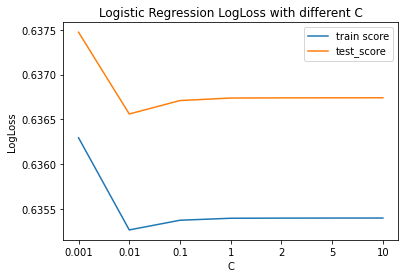

In [216]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

Cs = [0.001,0.01,0.1,1,2,5,10]
lr_acc_train = []
lr_acc_test = []
for C in Cs:
    LR_model = LogisticRegression(C=C,solver='liblinear',class_weight="balanced").fit(X_train,y_train)
    lr_acc_train.append(metrics.log_loss(y_train,LR_model.predict_proba(X_train)))
    lr_acc_test.append(metrics.log_loss(y_test,LR_model.predict_proba(X_test)))
    #lr_acc_train.append(metrics.f1_score(y_train,LR_model.predict(X_train),average = 'weighted'))
    #lr_acc_test.append(metrics.f1_score(y_test,LR_model.predict(X_test),average = 'weighted'))
    
plt.plot(list(range(len(Cs))),lr_acc_train,label="train score")
plt.plot(list(range(len(Cs))),lr_acc_test,label="test_score")
plt.xlabel("C")
plt.xticks(list(range(len(Cs))),Cs)
plt.ylabel("LogLoss")
plt.legend()
plt.title("Logistic Regression LogLoss with different C")  

We pick the optimal $C=0.01$, then evaluate the model starting with F1-score, Jaccard similarity and Log loss as follows

In [217]:
C = 0.01
LR_model = LogisticRegression(C=C,solver='liblinear',class_weight="balanced").fit(X_train,y_train)

print("Train set Accuracy(f1): ", metrics.f1_score(y_train, LR_model.predict(X_train),average='weighted'))
print("Test set Accuracy(f1): ", metrics.f1_score(y_test, LR_model.predict(X_test),average='weighted'))

print("Train set Accuracy(Jaccard): ", metrics.jaccard_similarity_score(y_train, LR_model.predict(X_train)))
print("Test set Accuracy(Jaccard): ", metrics.jaccard_similarity_score(y_test, LR_model.predict(X_test)))

print("Train set LogLoss: ", metrics.log_loss(y_train,LR_model.predict_proba(X_train)))
print("Test set LogLoss: ", metrics.log_loss(y_test,LR_model.predict_proba(X_test)))

Train set Accuracy(f1):  0.6533658370312363
Test set Accuracy(f1):  0.6523804251557606
Train set Accuracy(Jaccard):  0.6406493081143044
Test set Accuracy(Jaccard):  0.6396561135371179
Train set LogLoss:  0.6352627308277011
Test set LogLoss:  0.6365589529389373


Also, we can compute the confussion matrix to check both type-I error and type-II error

In [218]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tn, fp, fn, tp = confusion_matrix(y_test, LR_model.predict(X_test)).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_test,LR_model.predict(X_test)))

16149 9120 4083 7288
              precision    recall  f1-score   support

           1       0.80      0.64      0.71     25269
           2       0.44      0.64      0.52     11371

   micro avg       0.64      0.64      0.64     36640
   macro avg       0.62      0.64      0.62     36640
weighted avg       0.69      0.64      0.65     36640



#### Random Forest Classification

For Random Forest, there's one important hyper-parameter that we have to tune, which is max_depth, maxmium depth of the trees. So we have to try different max_depth in order to find the optimal one so that the model is neither underfitted nor overfitted. And of course, we have to consider the unbalanced dataset. Conveniently, sklearn package can pass the "balanced" parameter to class_weight and thus deal with it automatically.

In [220]:
from sklearn.ensemble import RandomForestClassifier

Text(0.5, 1.0, 'Random Forest LogLoss with different D')

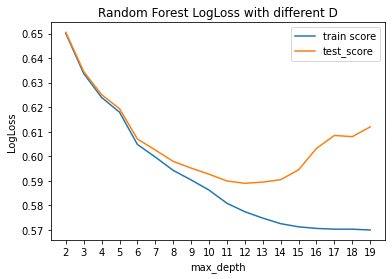

In [225]:
Ds = list(range(2,20))
rf_acc_train = []
rf_acc_test = []
for d in Ds:
    RF_model = RandomForestClassifier(max_depth=d,n_estimators = 100,class_weight="balanced").fit(X_train,y_train)
    rf_acc_train.append(metrics.log_loss(y_train,RF_model.predict_proba(X_train)))
    rf_acc_test.append(metrics.log_loss(y_test,RF_model.predict_proba(X_test)))
    #lr_acc_train.append(metrics.f1_score(y_train,LR_model.predict(X_train),average = 'weighted'))
    #lr_acc_test.append(metrics.f1_score(y_test,LR_model.predict(X_test),average = 'weighted'))
    
plt.plot(list(range(len(Ds))),rf_acc_train,label="train score")
plt.plot(list(range(len(Ds))),rf_acc_test,label="test_score")
plt.xlabel("max_depth")
plt.xticks(list(range(len(Ds))),Ds)
plt.ylabel("LogLoss")
plt.legend()
plt.title("Random Forest LogLoss with different D")  

As we can see from the graph, the model starts to overfit when max_depth is larger than 11, hence we can find the optimal $max_depth=11$.

In [227]:
d = 11
RF_model = RandomForestClassifier(max_depth=d,n_estimators = 100,class_weight="balanced").fit(X_train,y_train)

print("Train set Accuracy(f1): ", metrics.f1_score(y_train, RF_model.predict(X_train),average='weighted'))
print("Test set Accuracy(f1): ", metrics.f1_score(y_test, RF_model.predict(X_test),average='weighted'))

print("Train set Accuracy(Jaccard): ", metrics.jaccard_similarity_score(y_train, RF_model.predict(X_train)))
print("Test set Accuracy(Jaccard): ", metrics.jaccard_similarity_score(y_test, RF_model.predict(X_test)))

print("Train set LogLoss: ", metrics.log_loss(y_train,RF_model.predict_proba(X_train)))
print("Test set LogLoss: ", metrics.log_loss(y_test,RF_model.predict_proba(X_test)))

Train set Accuracy(f1):  0.6590158908204559
Test set Accuracy(f1):  0.6493797348202247
Train set Accuracy(Jaccard):  0.6456098692649909
Test set Accuracy(Jaccard):  0.6358078602620088
Train set LogLoss:  0.5810960412698488
Test set LogLoss:  0.5901396022641211


Also, we can compute the confussion matrix to check both type-I error and type-II error

In [228]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tn, fp, fn, tp = confusion_matrix(y_test, RF_model.predict(X_test)).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_test,RF_model.predict(X_test)))

15074 10195 3149 8222
              precision    recall  f1-score   support

           1       0.83      0.60      0.69     25269
           2       0.45      0.72      0.55     11371

   micro avg       0.64      0.64      0.64     36640
   macro avg       0.64      0.66      0.62     36640
weighted avg       0.71      0.64      0.65     36640



## 4. Results and Discussion

For both logistic regression model and random forest model, we already can get the model evaluation as follows

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| LogisticRegression | 0.639       | 0.652        | 0.636      |
| RandomForest       | 0.635       | 0.649        | 0.590       |

As we can see from the table above, logistic regression predicts a bit more accurate than random forest method, while has larger log-loss, which means random forest method predicts the probability more accurately. 

In [231]:
def plot_heat_maps(mat_list, titles = None, num_ticks = 10):
  fig,axn = plt.subplots(1, len(mat_list), sharey="row", 
                         figsize=(12, 7))
  plt.subplots_adjust(hspace=0.1, wspace=0.2)

#   print(axn.shape)
#   tick_ls = range(mat_list[0].shape[0])
#   ticks = np.linspace(0, len(tick_ls) - 1, num_ticks, dtype=np.int)
#   ticklabels = [tick_ls[idx] for idx in ticks]

  for i in range(len(mat_list)):
    cbar_ax = fig.add_axes([0.95, .3, .02, .4])
    sns.heatmap(mat_list[i], ax = axn[i], cmap="Blues", annot=True, 
                fmt='g', square=True, cbar_ax = cbar_ax, 
                yticklabels=["1","2"], xticklabels=["1","2"])
#     diag = get_diag(mat_list[i])
#     sns.scatterplot(x=range(len(diag)), y=diag, ax = axn[1,i], s=10)
#     diag = get_diag(mat_list[i])
    
#     axn[i].set_yticks(ticks)
#     axn[i].set_xticks(ticks)
#     axn[1,i].set_xlim(-1, len(diag)+1)
#     axn[1,i].set_ylim(-1.1,1.1)
    if titles:
      #assert len(mat_list) == len(titles)
        axn[i].set_xlabel(titles[i])
        axn[i].xaxis.set_label_position('top')

In [235]:
conf_lr = confusion_matrix(y_test, LR_model.predict(X_test))
conf_rf = confusion_matrix(y_test, RF_model.predict(X_test))

<AxesSubplot:title={'center':'Confusion Matrix for Logistic Regression'}>

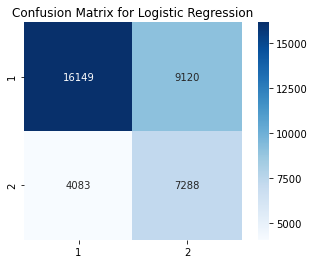

In [234]:
plt.title("Confusion Matrix for Logistic Regression")
sns.heatmap(conf_lr, annot=True, fmt='g', square = True, cmap ="Blues",
            xticklabels = ["1","2"], yticklabels = ["1","2"])

<AxesSubplot:title={'center':'Confusion Matrix for Random Forest'}>

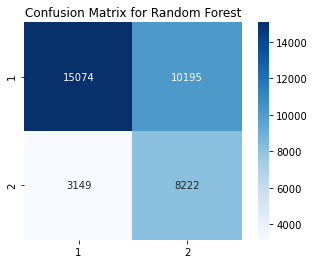

In [236]:
plt.title("Confusion Matrix for Random Forest")
sns.heatmap(conf_rf, annot=True, fmt='g', square = True, cmap ="Blues",
            xticklabels = ["1","2"], yticklabels = ["1","2"])

As we can see from the confusion matrx, the type II error is quite low for Random forest, which means that this method is more conservative, i.e. it would be less likely to predict an actual severe-2 accident to be severe 1. Thus it will protect drivers more conservatively, which is a good thing. As we consider type-I and type-II errors, we can find that in our problem type II error is much more dangerous. So we can even increase the weights on penalizing type II error further.

## 5. Conclusion

In this project, we develop machine learning models to predict the accident severity and the corresponding possibility. But this project has more potentials to be explored further. For instance, as we mentioned above, we have not yet consider the location as a feature, which should have been really important. And with GPS, it's actually a really appealing feature that we have to add. And with location as feature, we should be confident that we can increase the prediction accuracy much more.